In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
from scipy.stats import skew, kurtosis

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

import time
import pickle
# %pip install memory_profiler
import memory_profiler
%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [4]:
plt.style.use(
    "D:/qds lectures/sem4/Neural Data Science/Assignments/1/CL1/matplotlib_style.txt"
)

In [5]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

Electrophysiological recordings and related measurements of mouse brain slices

In [6]:
# META DATA

meta = pd.read_csv(
    "D:/qds lectures/sem4/Neural Data Science/data_practical03/data/m1_patchseq_meta_data.csv",
    sep="\t",
)


cells = meta["Cell"].values
layers = meta["Targeted layer"].values.astype("str") 
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)
# display(meta.head(2))

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


#### Measurements

- **Number of cells with measured depth: 1284**
  - Needed to understand the positioning of cells within the brain slice, which can influence their electrophysiological properties.

- **Number of cells with measured thickness: 1284**
  - Cortical thickness is a critical parameter which can vary between different brain regions and conditions.

- **Number of (successfully) reconstructed cells: 646**
  - Provides insights into their structural characteristics and potential connectivity.

- **Number of slices with two cells: 69**
  - Maybe used to perform comparative studies within the same microenvironment.


#### Madhavi:
Data preprocessing and analysis pipeline for neural data, involving loading metadata, cleaning data, setting up paths, and performing consistency checks. It also prepares for visualization with a specific matplotlib style and ensures reproducibility of results by setting a random seed.

### Transcriptomic data

Has transcriptomic gene expression counts for various samples collected on different measurement occasions

In [7]:
# READ COUNTS

data_exons = pd.read_csv(
    "D:/qds lectures/sem4/Neural Data Science/data_practical03/data/m1_patchseq_exon_counts.csv.gz",
    na_filter=False,
    index_col=0,
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


#### Madhavi
Reads exon count data from a compressed CSV file, transposes the data for proper orientation, ensures consistency with cell names from the metadata, and extracts gene names. It prepares the data for further analysis, likely involving gene expression analysis or machine learning tasks in the context of neural data science.

In [8]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# GENE LENGTH --> genomic structure (lengths of exons, introns, and the total gene length) for each gene.

data = pd.read_csv(
    "D:/qds lectures/sem4/Neural Data Science/data_practical03/data/gene_lengths.txt"
)
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

# data.head(2)

#### Madhavi:
This part of the code ensures the integrity of gene length data by verifying the gene IDs match those from the exon count data (genes). It then extracts exon and intron lengths from the gene length dataset, preparing these values for use in subsequent analyses. This type of data is crucial for understanding gene structure and potentially correlating it with gene expression levels or other biological characteristics in neural data science research.

### Cluster colors

In [38]:
cluster_colors = np.load(
    "D:/qds lectures/sem4/Neural Data Science/data_practical03/data/cluster_colors.npy"
)

In [39]:
cluster_colors.shape

(1329,)

In [40]:
rna_type = np.load(
    "D:/qds lectures/sem4/Neural Data Science/data_practical03/data/rna_type.npy",
    allow_pickle=True,
)

In [41]:
rna_type.shape

(1329,)

#### Madhavi:
Loading data from NumPy .npy files

In [42]:
pickle_in = open(
    "D:/qds lectures/sem4/Neural Data Science/data_practical03/data/dict_rna_type_colors.pkl",
    "rb",
)
dict_rna_type_colors = pickle.load(pickle_in)

In [43]:
len(dict_rna_type_colors)

88

#### Madhavi:
Retrieve and load a pre-saved dictionary (dict_rna_type_colors) from a pickle file. The loaded dictionary likely contains mappings between RNA types and corresponding colors, which could be used for visualizing or categorizing RNA data in neural data science analyses.

### Electrophysiological features

In [45]:
# EPHYS DATA

ephysData = pd.read_csv(
    "D:/qds lectures/sem4/Neural Data Science/data_practical03/data/m1_patchseq_ephys_features.csv"
)
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


#### Madhavi:
Reads ephys data from a CSV file, processes it by mapping cell IDs to their respective ephys measurements, and aligns this data with a predefined list of cells (cells).

In [46]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])  #log transformation
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)  # standardize filtered data
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [48]:
np.sum(np.isnan(ephysData_filtered))

0

In [107]:
display(ephysData_filtered)

array([], shape=(0, 17), dtype=float64)

#### Madhavi:
- Excludes specified features (features_exclude).
- Applies logarithmic transformation to specified features (features_log).
- Removes rows with NaN values.
- Standardizes the data to have a mean of zero and a standard deviation of one.
- Checks for any remaining NaN values in the processed data (ephysData_filtered).

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

# RQ 1: Different Statistics 

## Transcriptomics Data Statistics

### Lalitha:
Modifies summary statistics to represent collective summary of all features, changes output of all tests to be more readable

In [72]:
from scipy.stats import skew, kurtosis

exon_mean = np.mean(exonCounts, axis=0)
exon_std = np.std(exonCounts, axis=0)
exon_min = np.min(exonCounts, axis=0)
exon_max = np.max(exonCounts, axis=0)
exon_median = np.median(exonCounts, axis=0)
exon_q25 = np.percentile(exonCounts, 25, axis=0)
exon_q75 = np.percentile(exonCounts, 75, axis=0)
exon_skewness = skew(exonCounts, axis=0)
exon_kurtosis = kurtosis(exonCounts, axis=0)


def sumstats(data):
    return {
        "Mean": np.mean(data, axis=0),
        "Std Dev": np.std(data, axis=0),
        "Min": np.min(data, axis=0),
        "Max": np.max(data, axis=0),
        "Median": np.median(data, axis=0),
        "25th Percentile": np.percentile(data, 25, axis=0),
        "75th Percentile": np.percentile(data, 75, axis=0),
        "Skewness": skew(data, axis=0),
        "Kurtosis": kurtosis(data, axis=0),
    }


summary_stats = sumstats(exonCounts)
stat = pd.DataFrame(summary_stats)
display(stat.describe())

,Mean,Std Dev,Min,Max,Median,25th Percentile,75th Percentile,Skewness,Kurtosis
count,42466.000000,42466.000000,42466.0,4.246600e+04,42466.000000,42466.00000,42466.000000,42466.000000,42466.000000
mean,37.739546,84.380283,0.0,1.260244e+03,10.853718,2.16213,38.869307,18.432832,498.208921
std,344.968081,612.881066,0.0,1.029678e+04,198.228629,84.15304,416.445334,11.227878,462.071390
min,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.00000,0.000000,0.000000,-3.000000
25%,0.026336,0.519794,0.0,1.500000e+01,0.000000,0.00000,0.000000,7.909501,87.700793
50%,0.460497,5.553749,0.0,1.360000e+02,0.000000,0.00000,0.000000,16.654145,327.253019
75%,15.755643,68.315327,0.0,1.137000e+03,0.000000,0.00000,0.000000,28.008352,860.747113
max,48376.944319,86179.432985,0.0,1.536853e+06,30163.000000,15668.00000,57231.000000,36.414293,1324.000753


## Statistics for the Electrophysiological Data

In [74]:
ephys_mean = np.mean(ephysData_filtered, axis=0)
ephys_std = np.std(ephysData_filtered, axis=0)
ephys_min = np.min(ephysData_filtered, axis=0)
ephys_max = np.max(ephysData_filtered, axis=0)
ephys_median = np.median(ephysData_filtered, axis=0)
ephys_q25 = np.percentile(ephysData_filtered, 25, axis=0)
ephys_q75 = np.percentile(ephysData_filtered, 75, axis=0)
ephys_skewness = skew(ephysData_filtered, axis=0)
ephys_kurtosis = kurtosis(ephysData_filtered, axis=0)


def ephysstat(data):
    return {
        "Mean": np.mean(data, axis=0),
        "Standard Deviation": np.std(data, axis=0),
        "Minimum": np.min(data, axis=0),
        "Maximum": np.max(data, axis=0),
        "Median": np.median(data, axis=0),
        "25th Percentile": np.percentile(data, 25, axis=0),
        "75th Percentile": np.percentile(data, 75, axis=0),
        "Skewness": skew(data, axis=0),
        "Kurtosis": kurtosis(data, axis=0),
    }


ephys_sumstat = ephysstat(ephysData_filtered)
df = pd.DataFrame(ephys_sumstat)
display(df.describe())

,Mean,Standard Deviation,Minimum,Maximum,Median,25th Percentile,75th Percentile,Skewness,Kurtosis
count,1.700000e+01,1.700000e+01,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,-2.789132e-16,1.000000e+00,-2.494059,3.887087,-0.104977,-0.670162,0.556275,0.648516,1.690822
std,2.854523e-15,1.844650e-15,1.212430,1.366812,0.218477,0.104518,0.209139,1.098140,2.419281
min,-4.712729e-15,1.000000e+00,-4.271044,1.789956,-0.374327,-0.890334,0.108179,-1.155004,-0.698629
25%,-1.555232e-15,1.000000e+00,-3.697363,2.904289,-0.279863,-0.692945,0.397169,-0.254164,0.019754
50%,-3.540939e-16,1.000000e+00,-2.477667,3.382444,-0.185575,-0.647512,0.645631,0.587729,0.414199
75%,1.037133e-15,1.000000e+00,-1.480336,5.106139,0.055612,-0.622873,0.724038,1.616125,3.184683
max,7.803585e-15,1.000000e+00,-0.870856,6.278354,0.335845,-0.494769,0.783474,2.495237,7.936639


C:\Users\Lalitha Sivakumar\AppData\Local\Temp\ipykernel_24208\2266207515.py:28: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


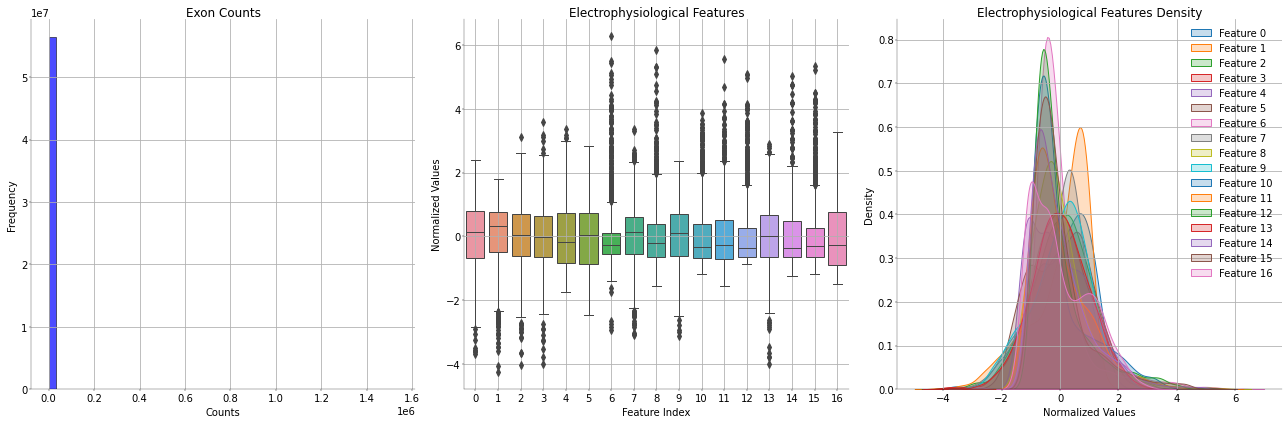

In [75]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(
    exonCounts.flatten(), bins=50, color="blue", alpha=0.7, ax=axes[0]
)  # exon count hist
axes[0].set_title("Exon Counts")
axes[0].set_xlabel("Counts")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

sns.boxplot(data=ephysData_filtered, ax=axes[1])  # boxplot
axes[1].set_title("Electrophysiological Features")
axes[1].set_xlabel("Feature Index")
axes[1].set_ylabel("Normalized Values")
axes[1].grid(True)

for i in range(ephysData_filtered.shape[1]):  # density
    sns.kdeplot(
        ephysData_filtered[:, i], label=f"Feature {i}", fill=True, ax=axes[2]
    )
axes[2].set_title("Electrophysiological Features Density")
axes[2].set_xlabel("Normalized Values")
axes[2].set_ylabel("Density")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## RQ 2: Normalizing and Transforming Data

#### 2.1 a. Electrophysiological Data --> Normality Check

Most features exhibit strong deviations from normality based on the very low p-values ---> not normally distributed.

In [82]:
from scipy.stats import shapiro

mean_ephys = np.mean(ephysData_filtered, axis=0)
median_ephys = np.median(ephysData_filtered, axis=0)
variance_ephys = np.var(ephysData_filtered, axis=0)
std_dev_ephys = np.std(ephysData_filtered, axis=0)

# Normality test used = Shapiro-Wilk test for each feature
shapiro_tests_ephys = [
    shapiro(ephysData_filtered[:, i])
    for i in range(ephysData_filtered.shape[1])
]

print("\nElectrophysiological Features Summary Statistics:")
for i, name in enumerate(ephysNames):
    if i < len(mean_ephys):
        # print(f"{name}:")
        # print(f"  Mean: {mean_ephys[i]}")
        # print(f"  Median: {median_ephys[i]}")
        # print(f"  Variance: {variance_ephys[i]}")
        # print(f"  Standard Deviation: {std_dev_ephys[i]}")
        print(
            f"  Shapiro-Wilk Test: Statistic={shapiro_tests_ephys[i].statistic}, p-value={shapiro_tests_ephys[i].pvalue}"
        )


Electrophysiological Features Summary Statistics:
  Shapiro-Wilk Test: Statistic=0.9701569676399231, p-value=7.140377101675017e-16
  Shapiro-Wilk Test: Statistic=0.8905872106552124, p-value=1.3537074194238992e-29
  Shapiro-Wilk Test: Statistic=0.9931542277336121, p-value=8.685532520757988e-06
  Shapiro-Wilk Test: Statistic=0.9971084594726562, p-value=0.01625298336148262
  Shapiro-Wilk Test: Statistic=0.9534215331077576, p-value=4.609720195571182e-20
  Shapiro-Wilk Test: Statistic=0.9872610569000244, p-value=2.4380808483215333e-09
  Shapiro-Wilk Test: Statistic=0.7264236211776733, p-value=5.125949782500181e-42
  Shapiro-Wilk Test: Statistic=0.9862657189369202, p-value=7.718840566717233e-10
  Shapiro-Wilk Test: Statistic=0.8842397928237915, p-value=2.7086651134472426e-30
  Shapiro-Wilk Test: Statistic=0.9880173802375793, p-value=6.058122892227402e-09
  Shapiro-Wilk Test: Statistic=0.8277348279953003, p-value=1.8334753047935845e-35
  Shapiro-Wilk Test: Statistic=0.8982333540916443, p-val

#### 2.1 b Normalizing Electrophysiological Data

Since the unit is raw read counts, we first check if gene length is a factor to be considered for normalization. This has to be considered, or else longer genes could appear to have higher expression simply because of length, which can distort comparisons.

C:\Users\Lalitha Sivakumar\AppData\Local\Temp\ipykernel_24208\3233486023.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


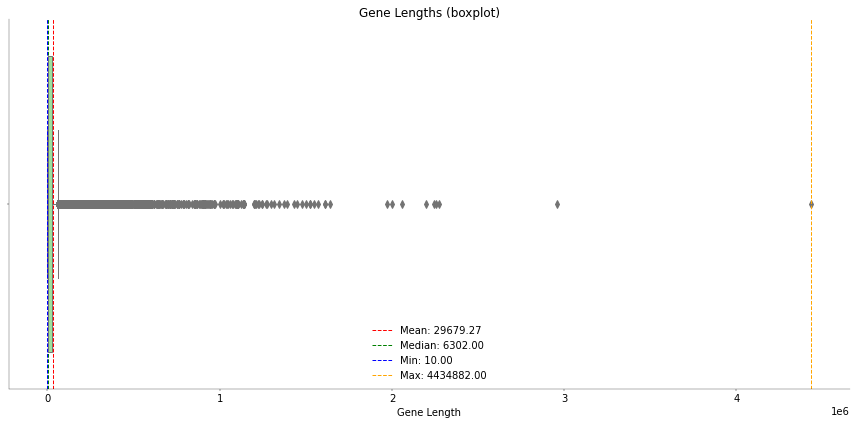

87842.83093687298

In [110]:
data["TotalLength"] = data["exon_bp"] + data["intron_bp"]
total_gene_lengths = data["TotalLength"].values

mean_length = np.mean(total_gene_lengths)  # stats
std_dev_length = np.std(total_gene_lengths)
median_length = np.median(total_gene_lengths)
min_length = np.min(total_gene_lengths)
max_length = np.max(total_gene_lengths)

plt.figure(figsize=(12, 6))  # boxplot
sns.boxplot(x=total_gene_lengths, color="lightgreen")
plt.title("Gene Lengths (boxplot)")
plt.xlabel("Gene Length")
plt.axvline(
    mean_length, color="r", linestyle="--", label=f"Mean: {mean_length:.2f}"
)
plt.axvline(
    median_length,
    color="g",
    linestyle="--",
    label=f"Median: {median_length:.2f}",
)
plt.axvline(
    min_length, color="b", linestyle="--", label=f"Min: {min_length:.2f}"
)
plt.axvline(
    max_length, color="orange", linestyle="--", label=f"Max: {max_length:.2f}"
)
plt.legend()

plt.tight_layout()
plt.show()

std_dev_length

- The gene lengths vary significantly, with a large standard deviation (87,842.83 bp) compared to the mean gene length (29,679.27 bp). The large range (from 10 bp to over 4 million bp) further supports this variability.

- The median gene length (6,302 bp) is much shorter than the mean gene length (29,679.27 bp), suggesting that a small number of very long genes are skewing the mean upwards

- Proceeding with TPM (Transcripts Per Million) normalization from raw gene counts here. TPM is more intuitive for comparing expression levels across samples with varied gene lengths, as the total TPM values in a sample sum up to a constant value = 1 mil.

### TPM Normalization

Calculating TPM:

$$
\text{TPM}_i = \frac{\frac{\text{Raw Count}_i}{\text{Gene Length}_i}}{\text{Total RPKs across all genes}} \times 10^6
$$

where:

- $\text{Raw Count}_i$ is the raw read count for gene $i$.
- $\text{Gene Length}_i$ is the length of gene $i$ in kilobases.
- $\text{Total RPKs across all genes}$ is the sum of RPK values for all genes in the sample.

In [109]:
print("Shape of ephysData_filtered:", ephysData_filtered.shape)
print("First few rows of ephysData_filtered:", ephysData_filtered[:5])

Shape of ephysData_filtered: (0, 17)
First few rows of ephysData_filtered: []


 Comparing how the different transformations change the two-dimensional visualization:

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    PowerTransformer,
)

# Ensure all values are strictly positive for Box-Cox by adding a constant
constant = np.abs(np.min(ephysData_filtered)) + 1e-6

# Normalize the filtered data
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

ephysData_min_max_scaled = min_max_scaler.fit_transform(ephysData_filtered)
ephysData_standard_scaled = standard_scaler.fit_transform(ephysData_filtered)

# Ensure ephysNames has the same number of elements as the number of columns in ephysData_filtered
ephysNames_filtered = ephysNames[~np.isin(ephysNames, features_exclude)]


def apply_transformation(data, names, transform_func, transform_name):
    transformed_data = transform_func(data)
    shapiro_results = [
        stats.shapiro(transformed_data[:, i])
        for i in range(transformed_data.shape[1])
    ]

    return transformed_data


# Trying different transformations
# Box-Cox Transformation
boxcox_transformer = PowerTransformer(method="box-cox")
if np.all(ephysData_filtered + constant > 0):
    ephysData_boxcox_transformed = apply_transformation(
        ephysData_filtered + constant,
        ephysNames_filtered,
        boxcox_transformer.fit_transform,
        "Box-Cox Transformed",
    )

# Yeo-Johnson Transformation
yeojohnson_transformer = PowerTransformer(method="yeo-johnson")
ephysData_yeojohnson_transformed = apply_transformation(
    ephysData_filtered,
    ephysNames_filtered,
    yeojohnson_transformer.fit_transform,
    "Yeo-Johnson Transformed",
)

In [28]:
# Function to print summary statistics for normalized data
def print_summary_statistics(data, names, method):
    mean = np.mean(data, axis=0)
    median = np.median(data, axis=0)
    variance = np.var(data, axis=0)
    std_dev = np.std(data, axis=0)

    print(f"\n{method} Summary Statistics:")
    for i, name in enumerate(names):
        print(f"{name}:")
        print(f"  Mean: {mean[i]}")
        print(f"  Median: {median[i]}")
        print(f"  Variance: {variance[i]}")
        print(f"  Standard Deviation: {std_dev[i]}")


# Print summary statistics for Min-Max Scaled data
print_summary_statistics(
    ephysData_min_max_scaled, ephysNames_filtered, "Min-Max Scaled"
)

# Print summary statistics for Z-score Normalized data
print_summary_statistics(
    ephysData_standard_scaled, ephysNames_filtered, "Z-score Normalized"
)

# Print summary statistics for Box-Cox Transformed data
if np.all(ephysData_filtered + constant > 0):
    print_summary_statistics(
        ephysData_boxcox_transformed,
        ephysNames_filtered,
        "Box-Cox Transformed",
    )

# Print summary statistics for Yeo-Johnson Transformed data
print_summary_statistics(
    ephysData_yeojohnson_transformed,
    ephysNames_filtered,
    "Yeo-Johnson Transformed",
)


Min-Max Scaled Summary Statistics:
AP amplitude (mV):
  Mean: 0.6062836950817737
  Median: 0.6287521639685558
  Variance: 0.026888568819823565
  Standard Deviation: 0.16397734239773362
AP amplitude adaptation index:
  Mean: 0.7046764901330673
  Median: 0.7600872405655147
  Variance: 0.02722146092242837
  Standard Deviation: 0.164989275173959
AP coefficient of variation:
  Mean: 0.5631355880479443
  Median: 0.5709006619910559
  Variance: 0.019496229283824083
  Standard Deviation: 0.1396288984552413
AP threshold (mV):
  Mean: 0.5266966158628565
  Median: 0.5248123691342302
  Variance: 0.01729179908429168
  Standard Deviation: 0.13149828548042625
AP width (ms):
  Mean: 0.34000270562770707
  Median: 0.3035714285714358
  Variance: 0.03853994472057081
  Standard Deviation: 0.19631593088837904
Afterhyperpolarization (mV):
  Mean: 0.46650866493559584
  Median: 0.4754945451133724
  Variance: 0.03545141720538824
  Standard Deviation: 0.18828546732392343
ISI adaptation index:
  Mean: 0.318912697

In [29]:
def shapiro_wilk_pvalues(data, names):
    pvalues = {}

    # Shapiro-Wilk p-values for Min-Max Scaled data
    min_max_scaled_pvalues = [
        stats.shapiro(data[:, i])[1] for i in range(data.shape[1])
    ]
    pvalues["Min-Max Scaled"] = dict(zip(names, min_max_scaled_pvalues))

    # Shapiro-Wilk p-values for Z-score Normalized data
    standard_scaled_pvalues = [
        stats.shapiro(ephysData_standard_scaled[:, i])[1]
        for i in range(ephysData_standard_scaled.shape[1])
    ]
    pvalues["Z-score Normalized"] = dict(zip(names, standard_scaled_pvalues))

    # Shapiro-Wilk p-values for Box-Cox Transformed data
    boxcox_transformed_pvalues = [
        stats.shapiro(ephysData_boxcox_transformed[:, i])[1]
        for i in range(ephysData_boxcox_transformed.shape[1])
    ]
    pvalues["Box-Cox Transformed"] = dict(
        zip(names, boxcox_transformed_pvalues)
    )

    # Shapiro-Wilk p-values for Yeo-Johnson Transformed data
    yeojohnson_transformed_pvalues = [
        stats.shapiro(ephysData_yeojohnson_transformed[:, i])[1]
        for i in range(ephysData_yeojohnson_transformed.shape[1])
    ]
    pvalues["Yeo-Johnson Transformed"] = dict(
        zip(names, yeojohnson_transformed_pvalues)
    )

    return pvalues


# Compute Shapiro-Wilk p-values for each transformation method
shapiro_wilk_pvalues = shapiro_wilk_pvalues(
    ephysData_filtered, ephysNames_filtered
)

# Display Shapiro-Wilk p-values for each transformation method
for method, pvalues in shapiro_wilk_pvalues.items():
    print(f"\nShapiro-Wilk p-values for {method} Data:")
    for name, pvalue in pvalues.items():
        print(f"{name}: {pvalue}")


Shapiro-Wilk p-values for Min-Max Scaled Data:
AP amplitude (mV): 7.140377101675017e-16
AP amplitude adaptation index: 1.3537074194238992e-29
AP coefficient of variation: 8.685532520757988e-06
AP threshold (mV): 0.01625298336148262
AP width (ms): 4.609720195571182e-20
Afterhyperpolarization (mV): 2.4380808483215333e-09
ISI adaptation index: 5.125949782500181e-42
ISI coefficient of variation: 7.718840566717233e-10
Input resistance (MOhm): 2.7086651134472426e-30
Latency (ms): 6.058122892227402e-09
Max number of APs: 1.8334753047935845e-35
Membrane time constant (ms): 1.0388755009516408e-28
Rebound (mV): 6.644018447857185e-40
Resting membrane potential (mV): 0.002795011969283223
Rheobase (pA): 2.3408726544007877e-33
Sag ratio: 1.2168810843947967e-37
Upstroke-to-downstroke ratio: 4.46071308922343e-25

Shapiro-Wilk p-values for Z-score Normalized Data:
AP amplitude (mV): 7.140377101675017e-16
AP amplitude adaptation index: 1.3537074194238992e-29
AP coefficient of variation: 8.6855325207579

C:\Users\Lalitha Sivakumar\AppData\Local\Temp\ipykernel_24208\4251960504.py:48: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


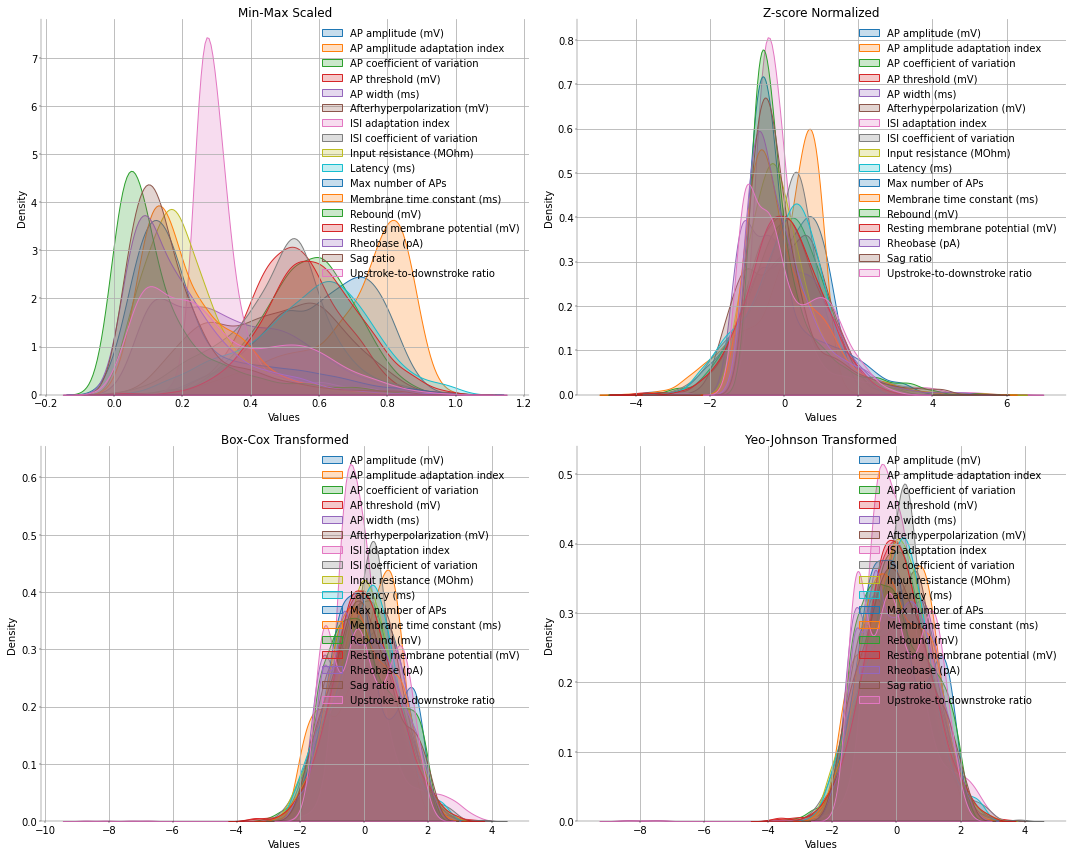

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    PowerTransformer,
)

# Ensure all values are strictly positive for Box-Cox by adding a constant
constant = np.abs(np.min(ephysData_filtered)) + 1e-6

# Normalize the filtered data
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

ephysData_min_max_scaled = min_max_scaler.fit_transform(ephysData_filtered)
ephysData_standard_scaled = standard_scaler.fit_transform(ephysData_filtered)

# Box-Cox Transformation
boxcox_transformer = PowerTransformer(method="box-cox")
if np.all(ephysData_filtered + constant > 0):
    ephysData_boxcox_transformed = boxcox_transformer.fit_transform(
        ephysData_filtered + constant
    )

# Yeo-Johnson Transformation
yeojohnson_transformer = PowerTransformer(method="yeo-johnson")
ephysData_yeojohnson_transformed = yeojohnson_transformer.fit_transform(
    ephysData_filtered
)


# Function to plot density plots in a grid
def plot_density_grid(datasets, names, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    for i, (data, name, title) in enumerate(zip(datasets, names, titles)):
        ax = axes[i // cols, i % cols]
        for j in range(data.shape[1]):
            sns.kdeplot(data[:, j], ax=ax, label=name[j], fill=True)
        ax.set_title(title)
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


# Prepare data and titles for plotting
datasets = [
    ephysData_min_max_scaled,
    ephysData_standard_scaled,
    ephysData_boxcox_transformed,
    ephysData_yeojohnson_transformed,
]
names = [
    ephysNames_filtered,
    ephysNames_filtered,
    ephysNames_filtered,
    ephysNames_filtered,
]
titles = [
    "Min-Max Scaled",
    "Z-score Normalized",
    "Box-Cox Transformed",
    "Yeo-Johnson Transformed",
]

# Plot density plots in a 2x2 grid
plot_density_grid(datasets, names, titles, rows=2, cols=2)

Please add 1 line to explain ""

In [ ]:
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Transpose the exonCounts matrix
exonCounts_transposed = exonCounts.transpose()


# Flatten the transposed exon counts
exonCounts_flat = exonCounts_transposed.flatten()
shapiro_test_exon = stats.shapiro(exonCounts_flat)
print(
    f"Shapiro-Wilk Test: Statistic={shapiro_test_exon.statistic}, p-value={shapiro_test_exon.pvalue}"
)


# Summary statistics function
def summary_statistics(data, name):
    mean = np.mean(data)
    median = np.median(data)
    variance = np.var(data)
    std_dev = np.std(data)
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    shapiro_stat, shapiro_p = stats.shapiro(data)

    print(f"{name} Summary Statistics:")
    print(f"  Mean: {mean}")
    print(f"  Median: {median}")
    print(f"  Variance: {variance}")
    print(f"  Standard Deviation: {std_dev}")
    print(f"  Skewness: {skewness}")
    print(f"  Kurtosis: {kurtosis}")
    print(
        f"  Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}\n"
    )

Shapiro-Wilk Test: Statistic=0.021465718746185303, p-value=0.0


c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# Compute and print summary statistics for exon counts
summary_statistics(exonCounts_flat, "Exon Counts")


# Apply transformations and re-evaluate normality
def apply_transformations(data):
    print("Original Data:")
    summary_statistics(data, "Exon Counts")

    # Log Transformation (Adding 1 to avoid log(0))
    log_transformed = np.log1p(data)
    print("Log Transformation:")
    summary_statistics(log_transformed, "Log Transformed Exon Counts")

    # Square Root Transformation
    sqrt_transformed = np.sqrt(data)
    print("Square Root Transformation:")
    summary_statistics(sqrt_transformed, "Square Root Transformed Exon Counts")

    # Box-Cox Transformation (data must be positive, adding 1 to avoid zero values)
    boxcox_transformed, _ = stats.boxcox(data + 1)
    print("Box-Cox Transformation:")
    summary_statistics(boxcox_transformed, "Box-Cox Transformed Exon Counts")

    # Yeo-Johnson Transformation
    power_transformer = PowerTransformer(method="yeo-johnson")
    yeo_johnson_transformed = power_transformer.fit_transform(
        data.reshape(-1, 1)
    ).flatten()
    print("Yeo-Johnson Transformation:")
    summary_statistics(
        yeo_johnson_transformed, "Yeo-Johnson Transformed Exon Counts"
    )

    # Min-Max Scaling
    scaler = MinMaxScaler()
    min_max_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    print("Min-Max Scaling:")
    summary_statistics(min_max_scaled, "Min-Max Scaled Exon Counts")

    return (
        log_transformed,
        sqrt_transformed,
        boxcox_transformed,
        yeo_johnson_transformed,
        min_max_scaled,
    )


# Apply transformations to exon counts
(
    log_transformed,
    sqrt_transformed,
    boxcox_transformed,
    yeo_johnson_transformed,
    min_max_scaled,
) = apply_transformations(exonCounts_flat)

c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Exon Counts Summary Statistics:
  Mean: 37.739546127230646
  Median: 0.0
  Variance: 501734.5624948568
  Standard Deviation: 708.3322401916045
  Skewness: 585.6011839174737
  Kurtosis: 816592.560507063
  Shapiro-Wilk Test: Statistic=0.021465718746185303, p-value=0.0

Original Data:
Exon Counts Summary Statistics:
  Mean: 37.739546127230646
  Median: 0.0
  Variance: 501734.5624948568
  Standard Deviation: 708.3322401916045
  Skewness: 585.6011839174737
  Kurtosis: 816592.560507063
  Shapiro-Wilk Test: Statistic=0.021465718746185303, p-value=0.0

Log Transformation:
Log Transformed Exon Counts Summary Statistics:
  Mean: 0.5981905785484926
  Median: 0.0
  Variance: 2.504007059972279
  Standard Deviation: 1.582405466361981
  Skewness: 2.693278953381835
  Kurtosis: 6.216680162280609
  Shapiro-Wilk Test: Statistic=0.5631973147392273, p-value=0.0

Square Root Transformation:
Square Root Transformed Exon Counts Summary Statistics:
  Mean: 1.6262126471386895
  Median: 0.0
  Variance: 35.094978

c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Yeo-Johnson Transformed Exon Counts Summary Statistics:
  Mean: 1.5700166262382285e-16
  Median: -0.4319815573995708
  Variance: 1.0000000000000004
  Standard Deviation: 1.0000000000000002
  Skewness: 1.914863329487522
  Kurtosis: 1.7323965871286449
  Shapiro-Wilk Test: Statistic=0.5816501379013062, p-value=0.0

Min-Max Scaling:
Min-Max Scaled Exon Counts Summary Statistics:
  Mean: 2.4556379905710277e-05
  Median: 0.0
  Variance: 2.1242682617062995e-07
  Standard Deviation: 0.0004608978478693841
  Skewness: 585.6011839174671
  Kurtosis: 816592.5605070661
  Shapiro-Wilk Test: Statistic=0.021465718746185303, p-value=0.0



c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# # Histograms and Q-Q Plots function
# def plot_histogram_qq(data, name):
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.hist(data, bins=50, color="blue", alpha=0.7)
#     plt.title(f"Histogram of {name}")
#     plt.xlabel("Values")
#     plt.ylabel("Frequency")
#     plt.grid(True)

#     plt.subplot(1, 2, 2)
#     stats.probplot(data, dist="norm", plot=plt)
#     plt.title(f"Q-Q Plot of {name}")
#     plt.xlabel("Theoretical Quantiles")
#     plt.ylabel("Sample Quantiles")
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()


# # Plot histograms and Q-Q plots for original and transformed data
# plot_histogram_qq(exonCounts_flat, "Exon Counts")
# plot_histogram_qq(log_transformed, "Log Transformed Exon Counts")
# plot_histogram_qq(sqrt_transformed, "Square Root Transformed Exon Counts")
# plot_histogram_qq(boxcox_transformed, "Box-Cox Transformed Exon Counts")
# plot_histogram_qq(
#     yeo_johnson_transformed, "Yeo-Johnson Transformed Exon Counts"
# )
# plot_histogram_qq(min_max_scaled, "Min-Max Scaled Exon Counts")

In [33]:
# Density Plot for Transformed Exon Count Data
def plot_density(data, title):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data, fill=True)
    plt.title(f"Density Plot of {title}")
    plt.xlabel("Values")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


plot_density(exonCounts_flat, "Original Exon Counts")
plot_density(log_transformed, "Log Transformed Exon Counts")
plot_density(sqrt_transformed, "Square Root Transformed Exon Counts")
plot_density(boxcox_transformed, "Box-Cox Transformed Exon Counts")
plot_density(yeo_johnson_transformed, "Yeo-Johnson Transformed Exon Counts")
plot_density(min_max_scaled, "Min-Max Scaled Exon Counts")

NameError: name 'exonCounts_flat' is not defined

Task 3 -- Visualizations

In [ ]:
%pip install umap-learn scikit-learn

   ---------------------------------------- 85.7/85.7 kB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 2.7/2.7 MB 10.1 MB/s eta 0:00:00
   ---------------------------------------- 56.9/56.9 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 28.1/28.1 MB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


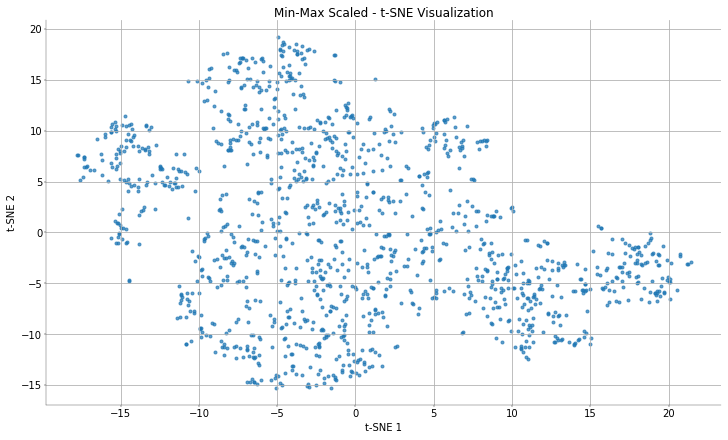

c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


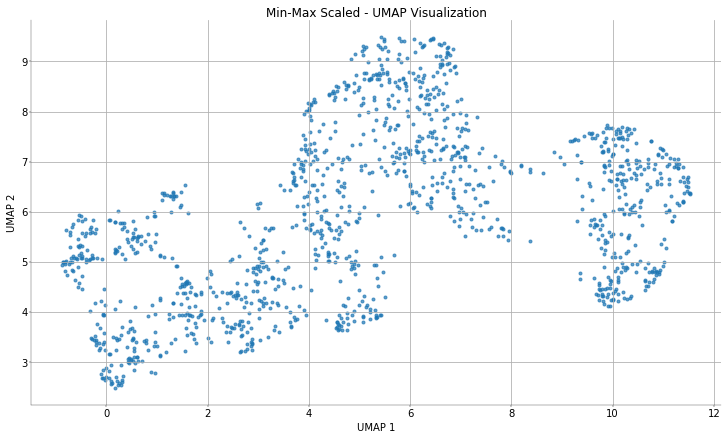

c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


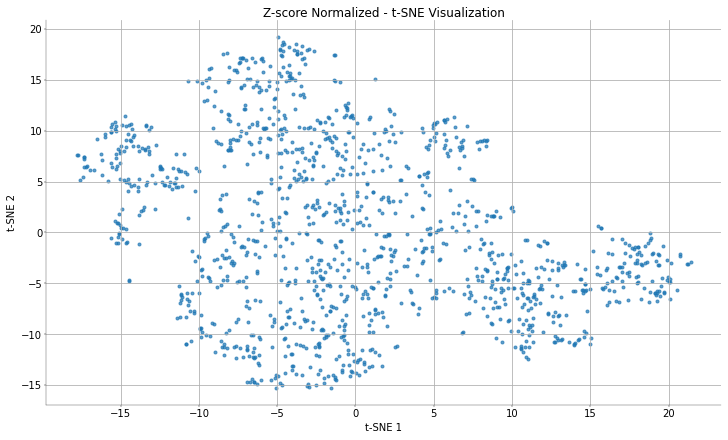

c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


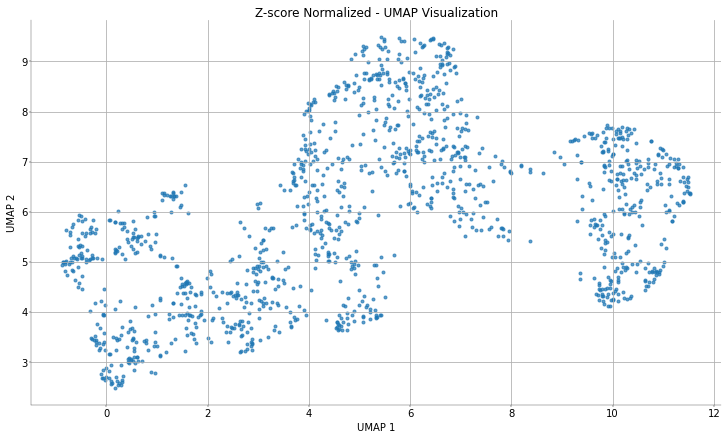

c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


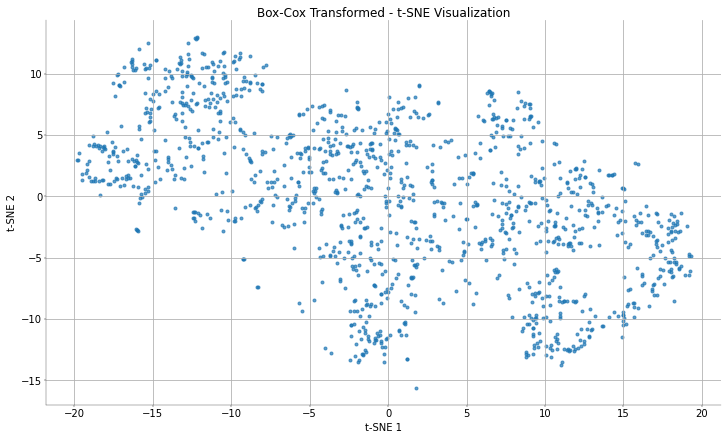

c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


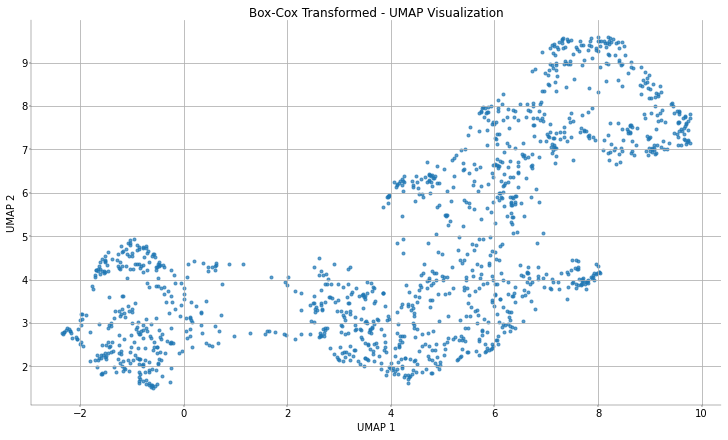

c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


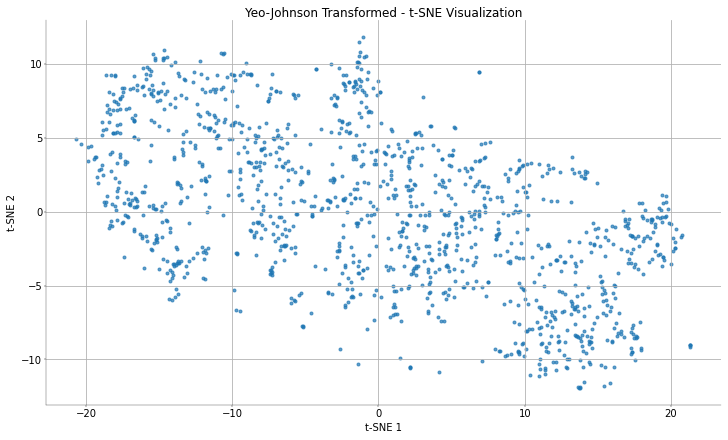

c:\Users\Lalitha Sivakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


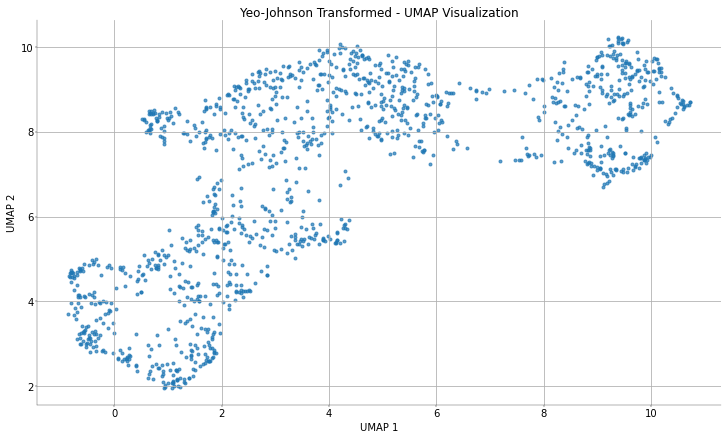

Distance Correlation for Min-Max Scaled:
t-SNE: 0.7641153954668165, UMAP: 0.7303303507572864
Distance Correlation for Z-score Normalized:
t-SNE: 0.718259747788742, UMAP: 0.6551136269553568
Distance Correlation for Box-Cox Transformed:
t-SNE: 0.6695623708733168, UMAP: 0.6820124196409763
Distance Correlation for Yeo-Johnson Transformed:
t-SNE: 0.6657458605783839, UMAP: 0.6721117211118397


In [ ]:
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr


# Helper function to apply and visualize t-SNE and UMAP
def visualize_tsne_umap(data, method):
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # t-SNE visualization
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(data_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.7)
    plt.title(f"{method} - t-SNE Visualization")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()

    # UMAP visualization
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    umap_results = umap_model.fit_transform(data_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.7)
    plt.title(f"{method} - UMAP Visualization")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.show()

    return tsne_results, umap_results


# Visualization for Min-Max Scaled data
tsne_min_max, umap_min_max = visualize_tsne_umap(
    ephysData_min_max_scaled, "Min-Max Scaled"
)

# Visualization for Z-score Normalized data
tsne_zscore, umap_zscore = visualize_tsne_umap(
    ephysData_standard_scaled, "Z-score Normalized"
)

# Visualization for Box-Cox Transformed data
if np.all(ephysData_filtered + constant > 0):
    tsne_boxcox, umap_boxcox = visualize_tsne_umap(
        ephysData_boxcox_transformed, "Box-Cox Transformed"
    )

# Visualization for Yeo-Johnson Transformed data
tsne_yeojohnson, umap_yeojohnson = visualize_tsne_umap(
    ephysData_yeojohnson_transformed, "Yeo-Johnson Transformed"
)


# Function to calculate distance correlation
def distance_correlation(tsne_results, umap_results, data_scaled):
    dist_tsne = squareform(pdist(tsne_results))
    dist_umap = squareform(pdist(umap_results))
    dist_high_dim = squareform(pdist(data_scaled))

    cor_tsne, _ = pearsonr(dist_tsne.flatten(), dist_high_dim.flatten())
    cor_umap, _ = pearsonr(dist_umap.flatten(), dist_high_dim.flatten())

    return cor_tsne, cor_umap


# Calculate and print distance correlations
cor_min_max_tsne, cor_min_max_umap = distance_correlation(
    tsne_min_max, umap_min_max, ephysData_min_max_scaled
)
cor_zscore_tsne, cor_zscore_umap = distance_correlation(
    tsne_zscore, umap_zscore, ephysData_standard_scaled
)
if np.all(ephysData_filtered + constant > 0):
    cor_boxcox_tsne, cor_boxcox_umap = distance_correlation(
        tsne_boxcox, umap_boxcox, ephysData_boxcox_transformed
    )
cor_yeojohnson_tsne, cor_yeojohnson_umap = distance_correlation(
    tsne_yeojohnson, umap_yeojohnson, ephysData_yeojohnson_transformed
)

print("Distance Correlation for Min-Max Scaled:")
print(f"t-SNE: {cor_min_max_tsne}, UMAP: {cor_min_max_umap}")

print("Distance Correlation for Z-score Normalized:")
print(f"t-SNE: {cor_zscore_tsne}, UMAP: {cor_zscore_umap}")

if np.all(ephysData_filtered + constant > 0):
    print("Distance Correlation for Box-Cox Transformed:")
    print(f"t-SNE: {cor_boxcox_tsne}, UMAP: {cor_boxcox_umap}")

print("Distance Correlation for Yeo-Johnson Transformed:")
print(f"t-SNE: {cor_yeojohnson_tsne}, UMAP: {cor_yeojohnson_umap}")